In [2]:
import sys
sys.path.append('../')
from callsetmerger.callsetmerger import Readers
from callsetmerger.recordcluster import convert_type_to_idx
from callsetmerger.recordcluster import GetVcfTypesKey
import trtools.utils.tr_harmonizer as trh
import itertools
import pandas as pd
import upsetplot
import matplotlib.pyplot as plt

In [3]:
# Creating a multi index for the Series data structure used by upset plot
idx=pd.MultiIndex.from_tuples(
    list(itertools.product([True,False],
                           repeat=len(convert_type_to_idx.keys()))),
    names=[i.name for i in convert_type_to_idx.keys()])

In [6]:
upset_data = pd.Series(index=idx, dtype='float64').fillna(0)
readers = Readers('/home/nmmsv/workspace/analysis/callset_merging/input/advntr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/hipstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/gangstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/eh.chr21.sorted.vcf.gz'.split(","))
while not readers.done:
    # Get mergeable calls
    rc_list = readers.getMergableCalls().RecordClusters
    for rc in rc_list:
        upset_data[rc.GetVcfTypesTuple()] += 1
        pass
    # Move on
    readers.goToNext()

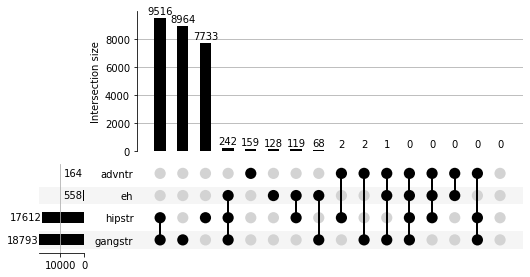

In [7]:
plt.style.use({'figure.facecolor':'white'})
upsetplot.plot(upset_data, show_counts='%d', sort_by='cardinality')
plt.show()


In [8]:
# Upset plot for each len(rc_list)
upset_data_rc1 = pd.Series(index=idx, dtype='float64').fillna(0)
upset_data_rc2 = pd.Series(index=idx, dtype='float64').fillna(0)
upset_data_rc3 = pd.Series(index=idx, dtype='float64').fillna(0)
upset_data_rc4 = pd.Series(index=idx, dtype='float64').fillna(0)
readers = Readers('/home/nmmsv/workspace/analysis/callset_merging/input/advntr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/hipstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/gangstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/eh.chr21.sorted.vcf.gz'.split(","))
while not readers.done:
    # Get mergeable calls
    rc_list = readers.getMergableCalls().RecordClusters
    for rc in rc_list:
        if len(rc_list) == 1:
            upset_data_rc1[rc.GetVcfTypesTuple()] += 1
        elif len(rc_list) == 2:
            upset_data_rc2[rc.GetVcfTypesTuple()] += 1
        elif len(rc_list) == 3:
            upset_data_rc3[rc.GetVcfTypesTuple()] += 1
        elif len(rc_list) >= 4:
            upset_data_rc4[rc.GetVcfTypesTuple()] += 1
        pass
    # Move on
    readers.goToNext()


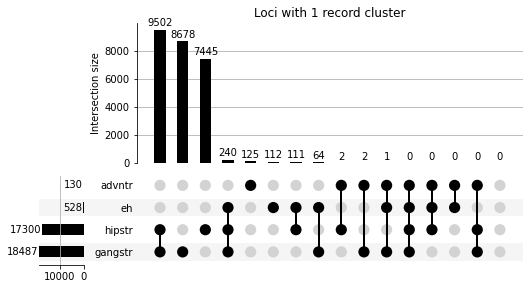

In [9]:
plt.style.use({'figure.facecolor':'white'})
upsetplot.plot(upset_data_rc1, show_counts='%d', sort_by='cardinality')
plt.title('Loci with 1 record cluster')
plt.show()

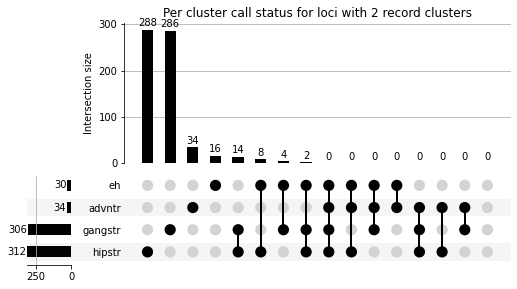

In [10]:
plt.style.use({'figure.facecolor':'white'})
upsetplot.plot(upset_data_rc2, show_counts='%d', sort_by='cardinality')
plt.title('Per cluster call status for loci with 2 record clusters')
plt.show()

# Anything more than 2 is zero

In [11]:
# Focusing on 2 record clusters per locus:
upset_data_per_locus_2_cluster = pd.Series(index=idx, dtype='float64').fillna(0)
readers = Readers('/home/nmmsv/workspace/analysis/callset_merging/input/advntr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/hipstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/gangstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/eh.chr21.sorted.vcf.gz'.split(","))
while not readers.done:
    # Get mergeable calls
    rc_list = readers.getMergableCalls().RecordClusters
    if len(rc_list) == 2:
        locus_vcf_types = zip(rc_list[0].GetVcfTypesTuple(), rc_list[1].GetVcfTypesTuple())
        per_locus_call_status = tuple([a or b for a, b in locus_vcf_types])
        upset_data_per_locus_2_cluster[per_locus_call_status] += 1
        pass
    # Move on
    readers.goToNext()




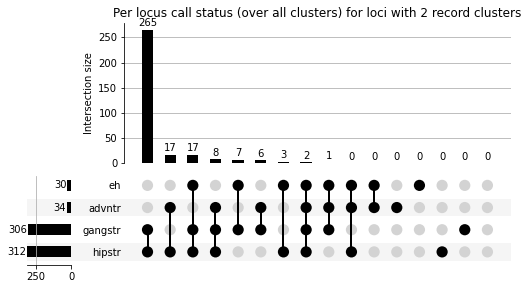

In [12]:
plt.style.use({'figure.facecolor':'white'})
upsetplot.plot(upset_data_per_locus_2_cluster, show_counts='%d', sort_by='cardinality')
plt.title('Per locus call status (over all clusters) for loci with 2 record clusters')
plt.show()

In [13]:
eh_index= list(GetVcfTypesKey()).index(trh.VcfTypes.eh)
gs_index= list(GetVcfTypesKey()).index(trh.VcfTypes.gangstr)
ad_index= list(GetVcfTypesKey()).index(trh.VcfTypes.advntr)
hp_index= list(GetVcfTypesKey()).index(trh.VcfTypes.hipstr)

gangstr_only_recs = []
hipstr_only_recs = []
readers = Readers('/home/nmmsv/workspace/analysis/callset_merging/input/advntr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/hipstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/gangstr.chr21.sorted.vcf.gz,/home/nmmsv/workspace/analysis/callset_merging/input/eh.chr21.sorted.vcf.gz'.split(","))
while not readers.done:
    # Get mergeable calls
    rc_list = readers.getMergableCalls().RecordClusters
    for rc in rc_list:
        # Only gangstr
        if not rc.vcf_types[eh_index] and \
            rc.vcf_types[gs_index] and \
            not rc.vcf_types[ad_index] and \
            not rc.vcf_types[hp_index]:
            rec = rc.record_objs[0]
            gangstr_only_recs.append(rec)
        # Only hipstr
        if not rc.vcf_types[eh_index] and \
            not rc.vcf_types[gs_index] and \
            not rc.vcf_types[ad_index] and \
            rc.vcf_types[hp_index]:
            rec = rc.record_objs[0]
            hipstr_only_recs.append(rec)
    # Move on
    readers.goToNext()

In [14]:
hipstr_only_pos = []
gangstr_only_pos = []
for rec in hipstr_only_recs:
    hipstr_only_pos.append((rec.hm_record.vcfrecord.POS,rec.canonical_motif))

for rec in gangstr_only_recs:
    gangstr_only_pos.append((rec.hm_record.vcfrecord.POS,rec.canonical_motif))

In [15]:
n = 0
for pg in gangstr_only_pos:
    for ph in hipstr_only_pos:
        if abs(pg[0] - ph[0]) < 10:
            n = n + 1
            # print('GangSTR: ', pg, '\tHipSTR: ', ph)
n

226